# Extracting interaction profiles

Interaction profiles (surface point cloud, ESP on a surface point cloud, and pharmacophores) can be generated for any arbituary conformer.

In [1]:
import open3d # open3d can occasionally cause issues during imports; importing it first can help alleviate that
from rdkit import Chem
from shepherd_score.conformer_generation import embed_conformer_from_smiles, charges_from_single_point_conformer_with_xtb
from shepherd_score.extract_profiles import get_atomic_vdw_radii, get_molecular_surface
from shepherd_score.extract_profiles import get_pharmacophores, get_electrostatic_potential, get_pharmacophores_dict

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Get a conformer with RDKit embedding and MMFF94 optimization then obtain charges from xTB.

In [2]:
ref_mol = embed_conformer_from_smiles('c1Cc2ccc(Cl)cc2C(=O)c1c3cc(N1nnc2cc(C)c(Cl)cc2c1=O)ccc3', MMFF_optimize=True)
partial_charges = charges_from_single_point_conformer_with_xtb(ref_mol)

### Extract surface
The vdW radii and the positions of each atom is used to generate a surface. Here we sample 200 points on the solvent accessible surface with a probe radius of 1.2 A. Note that the sampling is stochastic.

In [3]:
radii = get_atomic_vdw_radii(ref_mol)
surface = get_molecular_surface(ref_mol.GetConformer().GetPositions(), radii, num_points=200, probe_radius=1.2)
surface.shape

(200, 3)

### Extract electrostatic potential (ESP)
The ESP at each surface point is be computed from the partial charges.

In [4]:
esp = get_electrostatic_potential(ref_mol, partial_charges, surface)
esp.shape

(200,)

### Extract pharmacophores

Pharmacophores are extracted using pre-defined SMARTS patterns given an RDKit Mol object. Using `get_pharmacophores` returns a tuple of NumPy arrays corresponding to the type, position, and unit vector of each pharmacophore: `(pharm_types, pharm_positions, pharm_vectors)`. `get_pharmacophores_dict` is a helper function that provides an easy to interpret version. Non-directional pharmacophores (e.g., hydrophobe) have vectors set to the zero vector.

In [5]:
get_pharmacophores_dict(ref_mol, multi_vector=False)

{'Aromatic': {'P': [(-5.593005518875246,
    1.5822472905787488,
    -0.05055084292247661),
   (-0.3768898098974877, -2.434828068035075, -0.7221142421115143),
   (5.108419996512772, 0.8866522128929535, 0.3417185697262969)],
  'V': [(-0.5442705914243223, -0.5776441130965223, -0.6083558185104755),
   (-0.03950867265117138, 0.3696432813397431, -0.9283334041957824),
   (0.16904555253422235, -0.4837578087815462, 0.8587211326218055)]},
 'Acceptor': {'P': [(-2.574004507475966,
    0.5621257487600613,
    -1.8227072216635074),
   (3.213798188877814, -1.9164424655928365, -0.9050733817335864),
   (4.401828185691065, -1.5382920136235891, -0.8746418779811505),
   (1.585496320521838, 0.6480994875211756, 0.9901575256047624)],
  'V': [(0.5192774846023432, 0.31605477666593795, -0.7940152845705851),
   (-0.21484821261368212, -0.8623630243491875, -0.45844330049857696),
   (0.716843104950723, -0.5638119389543518, -0.4101853975669308),
   (-0.6683731188422039, 0.5416641857562932, 0.5097816040993605)]},
 '

In [6]:
pharm_types, pharm_pos, pharm_vecs = get_pharmacophores(ref_mol, multi_vector=False)

In [7]:
pharm_types.shape, pharm_pos.shape, pharm_vecs.shape

((15,), (15, 3), (15, 3))

The pharmacophore types are ordered (with 0 indexing) of the following list.

In [8]:
from shepherd_score.score.constants import P_TYPES
P_TYPES

('Acceptor',
 'Donor',
 'Aromatic',
 'Hydrophobe',
 'Halogen',
 'Cation',
 'Anion',
 'ZnBinder')

## Abstracted objects

We introduce the `Molecule` object that facilitates automatic generation of interaction profiles. It holds these profiles as attributes, alongside the RDKit `Mol` object. 

In [9]:
from shepherd_score.container import Molecule

The same procedure is used as above to extract each interaction profile. Note that if xTB partial charges were not supplied to `Molecule`, the object would compute ESP using MMFF94 partial charges which are not recommended.

In [10]:
molec = Molecule(ref_mol, num_surf_points=200, probe_radius=1.2,
                 partial_charges=partial_charges, pharm_multi_vector=False)

In [11]:
molec.surf_pos.shape, molec.surf_esp.shape

((200, 3), (200,))

In [12]:
molec.pharm_types.shape, molec.pharm_ancs.shape, molec.pharm_vecs.shape

((15,), (15, 3), (15, 3))

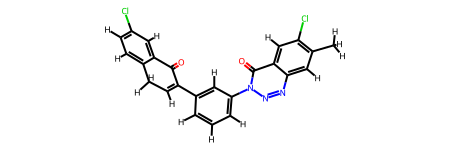

In [13]:
molec.mol # rdkit mol object